In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

In [2]:
rul = pd.read_csv("data/RUL_FD001.txt", header=None).values.reshape(-1)
df_train = pd.read_csv("data/train_FD001.txt", sep=' ', header=None)
df_train = df_train.drop(df_train.columns[-2:], axis=1)
df_test = pd.read_csv("data/test_FD001.txt", sep=' ', header=None)
df_test = df_test.drop(df_test.columns[-2:], axis=1)

In [3]:
column_selected = df_train[df_train.iloc[:, 0] == 1].std() > 1e-10
column_selected[0:5] = True

In [4]:
df_train = df_train.loc[:, column_selected]
df_test = df_test.loc[:, column_selected]

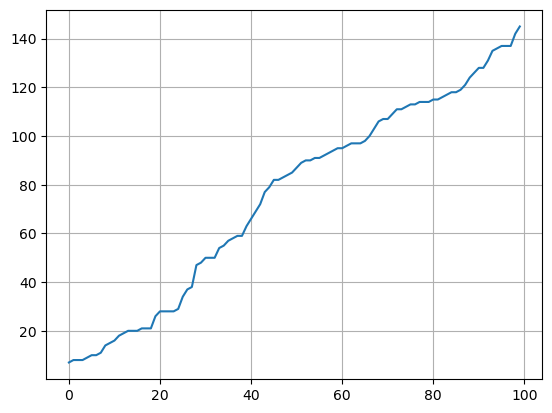

In [5]:
plt.plot(np.sort(rul))
plt.grid()

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train = scaler.fit_transform(df_train.iloc[:, 5:])
data_test = scaler.fit_transform(df_test.iloc[:, 5:])

In [7]:
window_size = 30
y_cap = 130
train_X = []
train_no = []
train_label = []

for i in range(1, 101):
    data_unit = data_train[df_train.iloc[:, 0] == i]
    train_X_unit = []
    train_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        train_X_unit.append(X_pad)
        train_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        train_X_unit.append(data_unit[j:j+window_size, :])
        train_no_unit.append(i)

    rul_unit = rul[i-1]
    y_unit = np.arange(rul_unit, 0, -1) - 1
    y_unit = y_unit[:min(rul_unit, len(data_unit))] # RUL of No.39 is larger than duration
    y_unit[y_unit>y_cap] = y_cap

    train_X += train_X_unit[:rul_unit]
    train_no += train_no_unit[:rul_unit]

    train_label += list(y_unit)

    #print((i, len(train_label), len(train_X), rul_unit, len(data_unit)))

train_X = torch.tensor(np.array(train_X), dtype=torch.float32)
train_label = torch.tensor(np.array(train_label), dtype=torch.float32)
train_no = torch.tensor(np.array(train_no), dtype=torch.int32)

In [8]:
test_X = []
test_label = []
test_no = []

for i in range(1, 101):
    data_unit = data_test[df_test.iloc[:, 0] == i]
    test_X_unit = []
    test_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        test_X_unit.append(X_pad)
        test_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        test_X_unit.append(data_unit[j:j+window_size, :])
        test_no_unit.append(i)

    rul_unit = len(data_unit)
    y_unit = np.arange(rul_unit, 0, -1) - 1
    y_unit[y_unit>y_cap] = y_cap

    test_X += test_X_unit
    test_no += test_no_unit
    test_label += list(y_unit)

test_X = torch.tensor(np.array(test_X), dtype=torch.float32)
test_label = torch.tensor(np.array(test_label), dtype=torch.float32)
test_no = torch.tensor(np.array(test_no), dtype=torch.int32)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Tanh()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_out = lstm_out[:, -1, :]
        final_out = self.act(final_out)
        output = self.fc(final_out)
        return output.reshape(-1)

In [10]:
input_dim = 30 * 14
hidden_dim = 128
output_dim = 1
model = LSTM(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
batch_size = 64

train_dataset = TensorDataset(train_X, train_label)
test_dataset = TensorDataset(test_X, test_label)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
num_epochs = 500
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    for i, (inputs, labels) in enumerate(train_loader):
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0 and (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("训练结束")

  2%|▏         | 9/500 [00:11<10:58,  1.34s/it]

Epoch [10/500], Step [100/118], Loss: 1205.5304


  4%|▍         | 20/500 [00:26<10:55,  1.36s/it]

Epoch [20/500], Step [100/118], Loss: 1082.6879


  6%|▌         | 29/500 [00:39<10:39,  1.36s/it]

Epoch [30/500], Step [100/118], Loss: 891.8301


  8%|▊         | 39/500 [00:53<11:02,  1.44s/it]

Epoch [40/500], Step [100/118], Loss: 984.1176


 10%|█         | 50/500 [01:08<09:49,  1.31s/it]

Epoch [50/500], Step [100/118], Loss: 997.8283


 12%|█▏        | 60/500 [01:20<08:48,  1.20s/it]

Epoch [60/500], Step [100/118], Loss: 569.3311


 14%|█▍        | 70/500 [01:32<08:53,  1.24s/it]

Epoch [70/500], Step [100/118], Loss: 745.9862


 16%|█▌        | 80/500 [01:45<09:03,  1.29s/it]

Epoch [80/500], Step [100/118], Loss: 515.1498


 18%|█▊        | 90/500 [01:58<08:52,  1.30s/it]

Epoch [90/500], Step [100/118], Loss: 536.1894


 20%|█▉        | 99/500 [02:10<08:49,  1.32s/it]

Epoch [100/500], Step [100/118], Loss: 197.8377


 22%|██▏       | 110/500 [02:25<08:43,  1.34s/it]

Epoch [110/500], Step [100/118], Loss: 139.2203


 24%|██▍       | 120/500 [02:38<08:26,  1.33s/it]

Epoch [120/500], Step [100/118], Loss: 82.6680


 26%|██▌       | 130/500 [02:51<08:10,  1.32s/it]

Epoch [130/500], Step [100/118], Loss: 170.9102


 28%|██▊       | 139/500 [03:03<08:00,  1.33s/it]

Epoch [140/500], Step [100/118], Loss: 53.8956


 30%|███       | 150/500 [03:18<07:55,  1.36s/it]

Epoch [150/500], Step [100/118], Loss: 44.7475


 32%|███▏      | 160/500 [03:32<07:34,  1.34s/it]

Epoch [160/500], Step [100/118], Loss: 55.9604


 34%|███▍      | 169/500 [03:44<07:17,  1.32s/it]

Epoch [170/500], Step [100/118], Loss: 83.2679


 36%|███▌      | 179/500 [03:57<07:06,  1.33s/it]

Epoch [180/500], Step [100/118], Loss: 28.9716


 38%|███▊      | 189/500 [04:10<06:53,  1.33s/it]

Epoch [190/500], Step [100/118], Loss: 187.0902


 40%|████      | 200/500 [04:25<07:21,  1.47s/it]

Epoch [200/500], Step [100/118], Loss: 168.3617


 42%|████▏     | 209/500 [04:38<06:32,  1.35s/it]

Epoch [210/500], Step [100/118], Loss: 55.2636


 44%|████▍     | 220/500 [04:52<06:14,  1.34s/it]

Epoch [220/500], Step [100/118], Loss: 7.8220


 46%|████▌     | 230/500 [05:06<06:04,  1.35s/it]

Epoch [230/500], Step [100/118], Loss: 27.4017


 48%|████▊     | 240/500 [05:19<05:46,  1.33s/it]

Epoch [240/500], Step [100/118], Loss: 7.6561


 50%|████▉     | 249/500 [05:31<05:35,  1.33s/it]

Epoch [250/500], Step [100/118], Loss: 54.4887


 52%|█████▏    | 259/500 [05:45<05:23,  1.34s/it]

Epoch [260/500], Step [100/118], Loss: 15.9082


 54%|█████▍    | 270/500 [06:00<05:09,  1.35s/it]

Epoch [270/500], Step [100/118], Loss: 42.2350


 56%|█████▌    | 279/500 [06:12<05:06,  1.39s/it]

Epoch [280/500], Step [100/118], Loss: 13.1132


 58%|█████▊    | 290/500 [06:27<04:41,  1.34s/it]

Epoch [290/500], Step [100/118], Loss: 41.5088


 60%|██████    | 300/500 [06:40<04:29,  1.35s/it]

Epoch [300/500], Step [100/118], Loss: 15.6092


 62%|██████▏   | 310/500 [06:54<04:14,  1.34s/it]

Epoch [310/500], Step [100/118], Loss: 9.2692


 64%|██████▍   | 320/500 [07:08<04:13,  1.41s/it]

Epoch [320/500], Step [100/118], Loss: 30.1337


 66%|██████▌   | 329/500 [07:20<03:53,  1.36s/it]

Epoch [330/500], Step [100/118], Loss: 13.7313


 68%|██████▊   | 339/500 [07:34<03:36,  1.35s/it]

Epoch [340/500], Step [100/118], Loss: 21.5406


 70%|██████▉   | 349/500 [07:49<03:46,  1.50s/it]

Epoch [350/500], Step [100/118], Loss: 11.6235


 72%|███████▏  | 360/500 [08:04<02:56,  1.26s/it]

Epoch [360/500], Step [100/118], Loss: 95.5466


 74%|███████▍  | 370/500 [08:16<02:34,  1.19s/it]

Epoch [370/500], Step [100/118], Loss: 9.6350


 76%|███████▌  | 380/500 [08:28<02:22,  1.19s/it]

Epoch [380/500], Step [100/118], Loss: 5.2040


 78%|███████▊  | 390/500 [08:40<02:13,  1.21s/it]

Epoch [390/500], Step [100/118], Loss: 1.4497


 80%|████████  | 400/500 [08:52<02:00,  1.20s/it]

Epoch [400/500], Step [100/118], Loss: 1.2492


 82%|████████▏ | 409/500 [09:03<01:54,  1.26s/it]

Epoch [410/500], Step [100/118], Loss: 0.9218


 84%|████████▍ | 420/500 [09:18<01:49,  1.37s/it]

Epoch [420/500], Step [100/118], Loss: 121.5261


 86%|████████▌ | 430/500 [09:32<01:33,  1.34s/it]

Epoch [430/500], Step [100/118], Loss: 84.1574


 88%|████████▊ | 440/500 [09:45<01:20,  1.33s/it]

Epoch [440/500], Step [100/118], Loss: 0.8077


 90%|█████████ | 450/500 [09:58<01:07,  1.35s/it]

Epoch [450/500], Step [100/118], Loss: 8.7203


 92%|█████████▏| 459/500 [10:11<00:58,  1.44s/it]

Epoch [460/500], Step [100/118], Loss: 0.7239


 94%|█████████▍| 470/500 [10:26<00:40,  1.35s/it]

Epoch [470/500], Step [100/118], Loss: 0.8518


 96%|█████████▌| 480/500 [10:40<00:26,  1.33s/it]

Epoch [480/500], Step [100/118], Loss: 11.9366


 98%|█████████▊| 489/500 [10:52<00:14,  1.34s/it]

Epoch [490/500], Step [100/118], Loss: 2.3950


100%|█████████▉| 499/500 [11:06<00:01,  1.40s/it]

Epoch [500/500], Step [100/118], Loss: 3.8658


100%|██████████| 500/500 [11:07<00:00,  1.33s/it]

训练结束


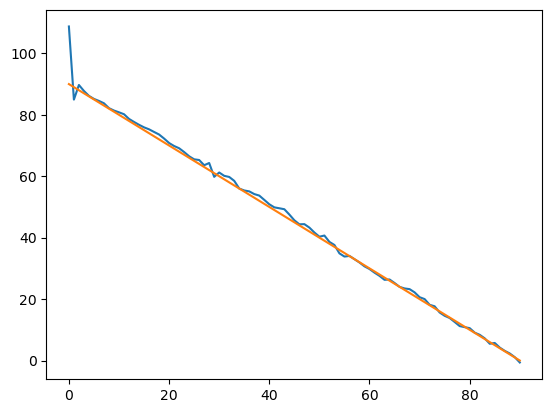

In [13]:
model.eval()
pred = model(train_X[train_no==5]).detach().numpy()
plt.plot(pred)
plt.plot(train_label[train_no==5])

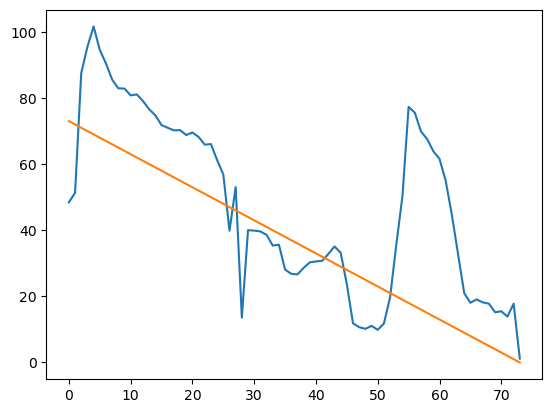

In [14]:
model.eval()
pred = model(test_X[test_no==50]).detach().numpy()
plt.plot(pred)
plt.plot(test_label[test_no==50])